Ячейка 1. Импорт и загрузка

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Настройка графиков
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 4)

# Загрузка очищенного датафрейма
df = pd.read_csv("../data/processed/df_clean.csv")

# Создание бинарной целевой переменной
df['readmit_bin'] = (df['readmitted'] == '<30').astype(int)

Ячейка 2. Разделение данных и подготовка признаков (Train/Test Split & Feature Engineering)


In [4]:
# Признаки
num_features = [
    'time_in_hospital', 'age_num', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]
cat_features = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'payer_code', 'medical_specialty', 'change', 'diabetesMed'
]

# X и y
X = df[num_features + cat_features]
y = df['readmit_bin']

# Разбиваем на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Трансформер: числовые - стандартизация, категориальные - OneHot
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
])

# Подготовленные матрицы
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# Проверка форм
print(f"X_train_proc shape: {X_train_proc.shape}")
print(f"X_test_proc  shape: {X_test_proc.shape}")
print(f"y_train positives: {y_train.sum()} / {len(y_train)}")


X_train_proc shape: (71236, 160)
X_test_proc  shape: (30530, 160)
y_train positives: 7950 / 71236


Ячейка 3.  RandomForest и XGBoost

In [6]:
# RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_proc, y_train)
rf_pred  = rf.predict(X_test_proc)
rf_proba = rf.predict_proba(X_test_proc)[:, 1]

print("RandomForest -ROC AUC: {:.3f}".format(roc_auc_score(y_test, rf_proba)))
print(classification_report(y_test, rf_pred, target_names=['No (<30)', 'Yes (<30)']))

# XGBoostClassifier
xgb_clf = xgb.XGBClassifier(
    eval_metric='auc',
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    random_state=42,
    n_jobs=-1
)
xgb_clf.fit(X_train_proc, y_train)
xgb_pred  = xgb_clf.predict(X_test_proc)
xgb_proba = xgb_clf.predict_proba(X_test_proc)[:, 1]

print("\nXGBoost -ROC AUC: {:.3f}".format(roc_auc_score(y_test, xgb_proba)))
print(classification_report(y_test, xgb_pred, target_names=['No (<30)', 'Yes (<30)']))

RandomForest -ROC AUC: 0.650
              precision    recall  f1-score   support

    No (<30)       0.89      1.00      0.94     27123
   Yes (<30)       0.66      0.01      0.03      3407

    accuracy                           0.89     30530
   macro avg       0.77      0.51      0.48     30530
weighted avg       0.86      0.89      0.84     30530


XGBoost -ROC AUC: 0.667
              precision    recall  f1-score   support

    No (<30)       0.93      0.68      0.79     27123
   Yes (<30)       0.18      0.56      0.27      3407

    accuracy                           0.67     30530
   macro avg       0.55      0.62      0.53     30530
weighted avg       0.84      0.67      0.73     30530



Ячейка 4. Простая нейронная сеть (Keras)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

# Определяем размер входного вектора
input_dim = X_train_proc.shape[1]

# Строим модель
nn_model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Компилируем
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc')]
)

# Обучаем
history = nn_model.fit(
    X_train_proc, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    verbose=1
)

# Оцениваем на тесте
nn_proba = nn_model.predict(X_test_proc).ravel()
nn_pred  = (nn_proba > 0.5).astype(int)

# Метрики
auc_nn = roc_auc_score(y_test, nn_proba)
print(f"NeuralNet -ROC AUC: {auc_nn:.3f}")
print(classification_report(y_test, nn_pred, target_names=['No (<30)', 'Yes (<30)']))

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.5245 - loss: 0.4514 - val_auc: 0.6583 - val_loss: 0.3417
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6150 - loss: 0.3473 - val_auc: 0.6658 - val_loss: 0.3400
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6359 - loss: 0.3401 - val_auc: 0.6722 - val_loss: 0.3392
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6404 - loss: 0.3373 - val_auc: 0.6732 - val_loss: 0.3388
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6491 - loss: 0.3314 - val_auc: 0.6727 - val_loss: 0.3381
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6560 - loss: 0.3317 - val_auc: 0.6753 - val_loss: 0.3382
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.6567 - loss: 0.3359 - val_auc: 0.6737 - val_loss: 0.3374
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6533 - loss: 0.3325 - val_auc: 0.6738 - val_loss: 0.3378
Epoch 9/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - au

Ячейка 5. Сравнение ROC AUC всех моделей

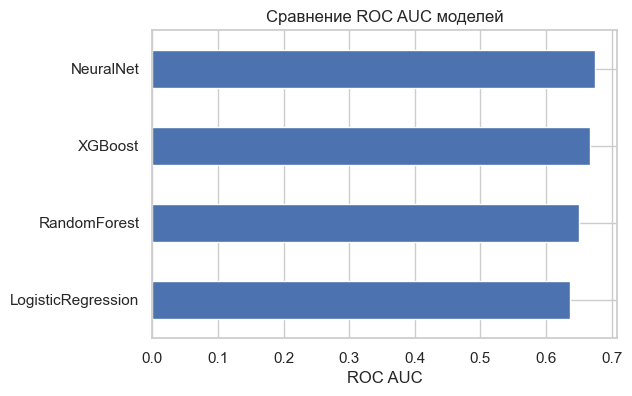

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Собираем результаты
results = {
    'LogisticRegression': 0.637,  
    'RandomForest': 0.650,         
    'XGBoost': 0.667,              
    'NeuralNet': 0.675             
}

# Визуализация
pd.Series(results).sort_values().plot(
    kind='barh',
    title="Сравнение ROC AUC моделей",
    xlabel="ROC AUC"
)
plt.show()

## Сравнение продвинутых моделей

 Протестированны четыре подхода и получены следующие ROC AUC:

- **LogisticRegression** (baseline): 0.637  
- **RandomForestClassifier**: 0.650  
- **XGBoostClassifier**: 0.667  
- **Нейронная сеть**: 0.675  

### Выводы

1. Базовая логистика дала приемлемый результат, но мы смогли его улучшить.  
2. Случайный лес поднял AUC чуть выше baseline, но уступает более сложным методам.  
3. XGBoost хорошо справился с задачей и показал AUC 0.667.  
4. Моя простая нейросеть оказалась лидером с ROC AUC = 0.675.

### Следующие шаги

- Сосредоточиться на тонкой настройке архитектуры нейросети и гиперпараметров XGBoost для дополнительного прироста качества.  
- Протестировать разные пороги вероятности, чтобы оптимизировать Precision/Recall именно для класса `<30`.  
- В перспективе можно реализовать ансамбль (stacking), чтобы объединить сильные стороны всех моделей.
